In [41]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from tensorflow.keras.models import load_model
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [1]:
def preprocess_image(img_path,apply_blur=True):
  img = cv2.imread(img_path)
  if img is None:
      print(f"[ERROR] Couldn't read: {img_path}")
      return None
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  if apply_blur:
      gray = cv2.GaussianBlur(gray, (5, 5), 0)
  clahe_img = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(gray)
  standardized = (clahe_img - np.mean(clahe_img)) / (np.std(clahe_img) + 1e-8)
  return standardized

def preprocess_dataset(input_dir, output_dir, apply_blur=True):
  for root, dirs, files in tqdm(os.walk(input_dir)):
    for file in files:
      if file.lower().endswith((".jpeg",".png",".jpg")):
        img_path = os.path.join(root, file)
        preprocessed_img = preprocess_image(img_path,apply_blur)
        processed_uint8 = ((preprocessed_img - preprocessed_img.min()) / (preprocessed_img.max() - preprocessed_img.min()) * 255).astype(np.uint8)
        relative_path = os.path.relpath(root, input_dir)
        save_dir = os.path.join(output_dir, relative_path)
        os.makedirs(save_dir, exist_ok=True)
        cv2.imwrite(os.path.join(save_dir, file), processed_uint8)

In [2]:
base_input_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray" 

train_dir = os.path.join(base_input_dir, "train")
val_dir   = os.path.join(base_input_dir, "val")
test_dir  = os.path.join(base_input_dir, "test")

output_base = "/kaggle/working/chest_xray_preprocessed"
preprocess_dataset(train_dir, os.path.join(output_base, "train"), apply_blur=False)
preprocess_dataset(val_dir,   os.path.join(output_base, "val"),   apply_blur=False)
preprocess_dataset(test_dir,  os.path.join(output_base, "test"),  apply_blur=False)

print("\nAll preprocessing is complete!")

3it [03:56, 78.88s/it]
3it [00:00,  4.28it/s]
3it [00:30, 10.15s/it]


All preprocessing is complete!


In [3]:
source_base_dir = "/kaggle/working/chest_xray_preprocessed"

all_files = []
for split in ['train', 'val', 'test']:
    for label in ['NORMAL', 'PNEUMONIA']:
        folder_path = os.path.join(source_base_dir, split, label)
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpeg', '.jpg', '.png')):
                all_files.append({
                    'filepath': os.path.join(folder_path, filename),
                    'label': label
                })

all_files_df = pd.DataFrame(all_files)
print(f"Found a total of {len(all_files_df)} preprocessed images.")


train_df, temp_df = train_test_split(
    all_files_df,
    test_size=0.30, 
    random_state=42,
    stratify=all_files_df['label'] 
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50, 
    random_state=42,
    stratify=temp_df['label'] 
)

print(f"Training set size: {len(train_df)} ({len(train_df)/len(all_files_df):.2%})")
print(f"Validation set size: {len(val_df)} ({len(val_df)/len(all_files_df):.2%})")
print(f"Test set size: {len(test_df)} ({len(test_df)/len(all_files_df):.2%})")


new_base_dir = "/kaggle/working/final_split_data"
if os.path.exists(new_base_dir):
    shutil.rmtree(new_base_dir)

# A helper function to copy files
def copy_files(dataframe, split_name):
    # Create the directory structure (e.g., /kaggle/working/final_split_data/train/NORMAL)
    target_dir_normal = os.path.join(new_base_dir, split_name, 'NORMAL')
    target_dir_pneumonia = os.path.join(new_base_dir, split_name, 'PNEUMONIA')
    os.makedirs(target_dir_normal, exist_ok=True)
    os.makedirs(target_dir_pneumonia, exist_ok=True)
    
    # Copy files
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc=f"Copying {split_name} files"):
        source_path = row['filepath']
        label = row['label']
        destination_path = os.path.join(new_base_dir, split_name, label, os.path.basename(source_path))
        shutil.copy(source_path, destination_path)

# Run the copy function for each new dataset split
copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')

print("\n--- Step 4: Verifying the new directory structure ---")
for split in ['train', 'val', 'test']:
    normal_count = len(os.listdir(os.path.join(new_base_dir, split, 'NORMAL')))
    pneumonia_count = len(os.listdir(os.path.join(new_base_dir, split, 'PNEUMONIA')))
    print(f"Total images in new '{split}' directory: {normal_count + pneumonia_count}")
    print(f"  -> NORMAL: {normal_count}")
    print(f"  -> PNEUMONIA: {pneumonia_count}")

print("\nAll data has been successfully merged, shuffled, and re-split!")

Found a total of 5856 preprocessed images.
Training set size: 4099 (70.00%)
Validation set size: 878 (14.99%)
Test set size: 879 (15.01%)


Copying test files: 100%|██████████| 879/879 [00:00<00:00, 2040.30it/s]


--- Step 4: Verifying the new directory structure ---
Total images in new 'train' directory: 4099
  -> NORMAL: 1108
  -> PNEUMONIA: 2991
Total images in new 'val' directory: 878
  -> NORMAL: 237
  -> PNEUMONIA: 641
Total images in new 'test' directory: 879
  -> NORMAL: 238
  -> PNEUMONIA: 641

All data has been successfully merged, shuffled, and re-split!


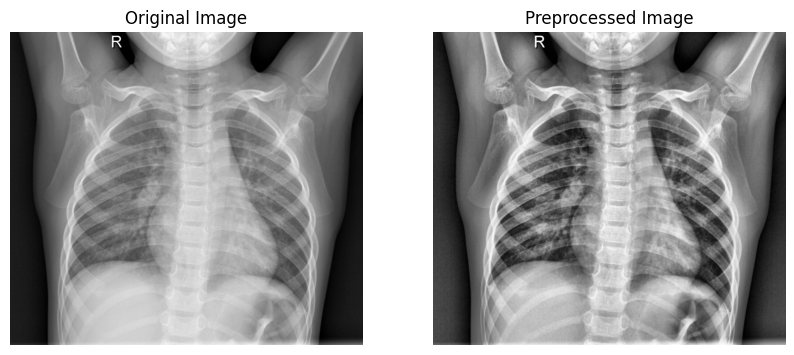

In [4]:
sample_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg"
original = cv2.imread(sample_path)
processed = preprocess_image(sample_path, apply_blur=True)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(processed, cmap='gray') 
plt.title("Preprocessed Image")
plt.axis("off")

plt.show()

In [9]:
train_dir = "/kaggle/working/final_split_data/train"
val_dir   = "/kaggle/working/final_split_data/val"
test_dir  = "/kaggle/working/final_split_data/test"

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.12,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='binary'
                                              #  color_mode='grayscale'
)         
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=(224,224),
                                           batch_size=32,
                                           class_mode='binary'
                                          #  /color_mode='grayscale'
)
                                      
test_data = val_datagen.flow_from_directory(test_dir,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='binary',
                                            shuffle=False
                                            # color_mode='grayscale'
)


Found 4099 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Found 879 images belonging to 2 classes.


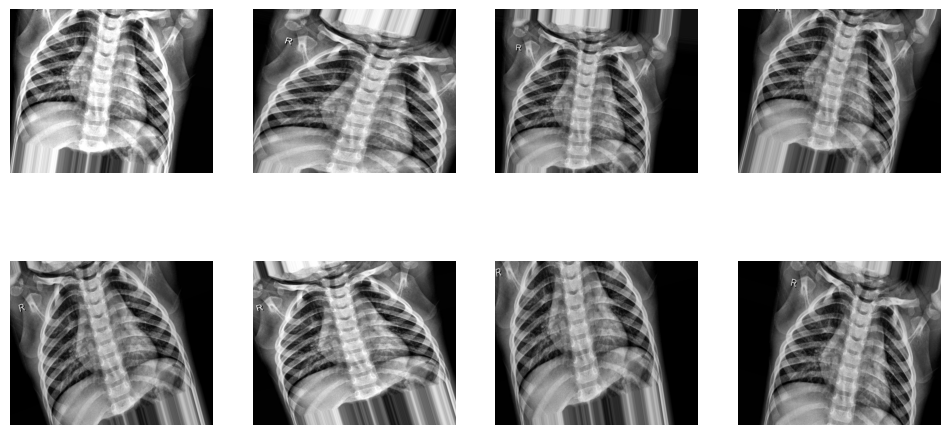

In [22]:
datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.12,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=False,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')
img_path = "/kaggle/working/chest_xray_preprocessed/train/NORMAL/IM-0117-0001.jpeg"

img = load_img(img_path)   
x = img_to_array(img)     
x = x.reshape((1,) + x.shape)  
plt.figure(figsize=(12,6))
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(2,4,i+1)  
    plt.imshow(batch[0])
    plt.axis('off')
    i += 1
    if i == 8:   
        break

plt.show()


In [23]:
class_labels = np.array(train_data.classes)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights_dict = dict(zip(np.unique(class_labels), class_weights))
print(f"Calculated Class Weights: {class_weights_dict}")

Calculated Class Weights: {0: 1.8497292418772564, 1: 0.6852223336676697}


In [12]:
def resnet50_model(input_shape=(224,224,3)): # Removed the fine_tune parameter for clarity
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# --- PHASE 1: FEATURE EXTRACTION ---
model_phase1 = resnet50_model()
model_phase1.layers[0].trainable = False # Explicitly freeze the base
model_phase1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


 
model_phase1.summary()





I0000 00:00:1757945464.436383      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757945464.437137      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,211,201 (99.99 MB)

 Trainable params: 2,623,489 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [13]:
model_phase1 = resnet50_model()
model_phase1.layers[0].trainable = False 
model_phase1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_path = "best_model_phase1.keras"
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True,verbose=1)
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss',verbose=1)

history_resnet = model_phase1.fit(
    train_data,
    validation_data=val_data,
    epochs=5, 
    callbacks=[early_stop, checkpoint],
    verbose=1,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1757945516.664694     173 service.cc:148] XLA service 0x7a1984005500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757945516.665493     173 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757945516.665517     173 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757945518.273106     173 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/129 ━━━━━━━━━━━━━━━━━━━━ 38:12 18s/step - accuracy: 0.4062 - loss: 0.8077

I0000 00:00:1757945523.678533     173 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.5163 - loss: 0.7956
Epoch 1: val_loss improved from inf to 0.58359, saving model to best_model_phase1.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 116s 770ms/step - accuracy: 0.5164 - loss: 0.7953 - val_accuracy: 0.8087 - val_loss: 0.5836
Epoch 2/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.6210 - loss: 0.6658
Epoch 2: val_loss improved from 0.58359 to 0.52918, saving model to best_model_phase1.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 88s 682ms/step - accuracy: 0.6211 - loss: 0.6657 - val_accuracy: 0.8052 - val_loss: 0.5292
Epoch 3/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.6789 - loss: 0.5971
Epoch 3: val_loss did not improve from 0.52918
129/129 ━━━━━━━━━━━━━━━━━━━━ 88s 680ms/step - accuracy: 0.6790 - loss: 0.5970 - val_accuracy: 0.7528 - val_loss: 0.5671
Epoch 4/5
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7191 - loss: 0.5842
Epoch 4: val_loss did not improve from 0.52918
129/129 ━━━━━━━━━━━━━━━━━━━

In [24]:
!ls -l /kaggle/working

total 399124
-rw-r--r-- 1 root root 282191586 Sep 15 14:51 best_model_fine_tuned.keras
-rw-r--r-- 1 root root 126500659 Sep 15 14:19 best_model_phase1.keras
drwxr-xr-x 5 root root      4096 Sep 15 14:01 chest_xray_preprocessed
drwxr-xr-x 5 root root      4096 Sep 15 14:06 final_split_data


In [28]:
model_to_fine_tune = resnet50_model() 
checkpoint_path = "best_model_phase1.keras"
model_to_fine_tune.load_weights(checkpoint_path)
base_model = model_to_fine_tune.layers[0]
base_model.trainable = True
for layer in base_model.layers: layer.trainable = True
fine_tune_at = 120
for layer in base_model.layers[:fine_tune_at]: layer.trainable = False
model_to_fine_tune.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("--- Fine-Tuning Model Summary ---")
model_to_fine_tune.summary()

--- Fine-Tuning Model Summary ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,211,201 (99.99 MB)

 Trainable params: 19,838,977 (75.68 MB)

 Non-trainable params: 6,372,224 (24.31 MB)

In [29]:
print("\nRe-creating data generators for fine-tuning...")

# Make sure your 'train_datagen' and 'val_datagen' objects are defined from before
train_data = train_datagen.flow_from_directory(
    "/kaggle/working/final_split_data/train", # Use the path to your final split data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)
val_data = val_datagen.flow_from_directory(
    "/kaggle/working/final_split_data/val", # Use the path to your final split data
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)
class_labels = np.array(train_data.classes)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(class_labels), y=class_labels)
class_weights_dict = dict(zip(np.unique(class_labels), class_weights))
print(f"Class weights for fine-tuning: {class_weights_dict}")



Re-creating data generators for fine-tuning...
Found 4099 images belonging to 2 classes.
Found 878 images belonging to 2 classes.
Class weights for fine-tuning: {0: 1.8497292418772564, 1: 0.6852223336676697}


In [31]:
fine_tuned_model_path = "best_model_fine_tuned.keras"
callbacks_fine_tune = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True), 
    ModelCheckpoint(fine_tuned_model_path, save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
]
initial_epochs = len(history_resnet.history['loss']) 
epochs_for_fine_tuning = 60
total_epochs = initial_epochs + epochs_for_fine_tuning
print(f"\nStarting fine-tuning from epoch {initial_epochs}")
history_fine_tune = model_to_fine_tune.fit(
    train_data,
    validation_data=val_data,
    epochs=total_epochs,
    initial_epoch=initial_epochs, 
    callbacks=callbacks_fine_tune,
    class_weight=class_weights_dict,
)


Starting fine-tuning from epoch 5...
Epoch 6/65
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8905 - loss: 0.2547
Epoch 6: val_loss improved from inf to 1.25284, saving model to best_model_fine_tuned.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 87s 669ms/step - accuracy: 0.8905 - loss: 0.2547 - val_accuracy: 0.5387 - val_loss: 1.2528 - learning_rate: 1.0000e-05
Epoch 7/65
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9027 - loss: 0.2382
Epoch 7: val_loss improved from 1.25284 to 0.27911, saving model to best_model_fine_tuned.keras
129/129 ━━━━━━━━━━━━━━━━━━━━ 86s 666ms/step - accuracy: 0.9027 - loss: 0.2382 - val_accuracy: 0.8872 - val_loss: 0.2791 - learning_rate: 1.0000e-05
Epoch 8/65
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.9060 - loss: 0.2284
Epoch 8: val_loss did not improve from 0.27911
129/129 ━━━━━━━━━━━━━━━━━━━━ 85s 654ms/step - accuracy: 0.9061 - loss: 0.2283 - val_accuracy: 0.7916 - val_loss: 0.5281 - learning_rate: 1.0000e-05
Epoch 9/65
129/129 

In [32]:

best_fine_tuned_model = load_model("best_model_fine_tuned.keras")

evaluation_results = best_fine_tuned_model.evaluate(test_data)

print(f"Test Loss: {evaluation_results[0]}")
print(f"Test Accuracy: {evaluation_results[1]}")
evaluation_results = best_fine_tuned_model.evaluate(train_data)

print(f"Training Loss: {evaluation_results[0]}")
print(f"Training Accuracy: {evaluation_results[1]}")
evaluation_results = best_fine_tuned_model.evaluate(val_data)

print(f"validation Loss: {evaluation_results[0]}")
print(f"validation Accuracy: {evaluation_results[1]}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 369ms/step - accuracy: 0.8959 - loss: 0.3039
Test Loss: 0.1801341027021408
Test Accuracy: 0.9431172013282776
129/129 ━━━━━━━━━━━━━━━━━━━━ 80s 618ms/step - accuracy: 0.9167 - loss: 0.1986
Training Loss: 0.20585334300994873
Training Accuracy: 0.912661612033844
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 320ms/step - accuracy: 0.9446 - loss: 0.1671
validation Loss: 0.17895832657814026
validation Accuracy: 0.9407745003700256


In [33]:
final_model_path = "/kaggle/working/pneumonia_detection_model_final.keras"

best_fine_tuned_model.save(final_model_path)

print(f"Model successfully saved to: {final_model_path}")

Model successfully saved to: /kaggle/working/pneumonia_detection_model_final.keras


In [34]:
!ls -lh /kaggle/working/

total 625M
-rw-r--r-- 1 root root 253M Sep 15 15:31 best_model_fine_tuned.keras
-rw-r--r-- 1 root root 121M Sep 15 14:19 best_model_phase1.keras
drwxr-xr-x 5 root root 4.0K Sep 15 14:01 chest_xray_preprocessed
drwxr-xr-x 5 root root 4.0K Sep 15 14:06 final_split_data
-rw-r--r-- 1 root root 253M Sep 15 15:58 pneumonia_detection_model_final.keras


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


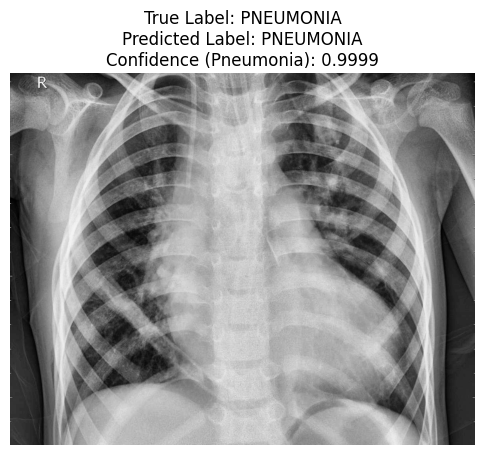

In [40]:

final_model_path = "/kaggle/working/pneumonia_detection_model_final.keras"
saved_model = tf.keras.models.load_model(final_model_path)
print("Model loaded successfully.")

final_test_dir = "/kaggle/working/final_split_data/test"
test_normal_dir = os.path.join(final_test_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(final_test_dir, 'PNEUMONIA')

label = random.choice(['NORMAL', 'PNEUMONIA'])
image_folder = os.path.join(final_test_dir, label)
random_image_filename = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, random_image_filename)


preprocessed_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

img_rgb = cv2.cvtColor(preprocessed_img, cv2.COLOR_GRAY2RGB)

img_resized = cv2.resize(img_rgb, (224, 224))

img_for_prediction = np.expand_dims(img_resized, axis=0)

img_for_prediction = img_for_prediction / 255.0

prediction = saved_model.predict(img_for_prediction)
prediction_proba = prediction[0][0] # Get the probability value

if prediction_proba > 0.5:
    prediction_label = 'PNEUMONIA'
else:
    prediction_label = 'NORMAL'

plt.figure(figsize=(6, 6))
plt.imshow(preprocessed_img, cmap='gray') 
plt.title(f"True Label: {label}\nPredicted Label: {prediction_label}\nConfidence (Pneumonia): {prediction_proba:.4f}")
plt.axis('off')
plt.show()

In [38]:
test_datagen = val_datagen
test_data = test_datagen.flow_from_directory(
    final_test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False 
)

y_true = test_data.classes

y_pred_proba = saved_model.predict(test_data, verbose=1)

y_pred = (y_pred_proba > 0.5).astype("int32")

y_pred = y_pred.flatten()

print("\nFinished getting predictions.")
print(f"Shape of true labels: {y_true.shape}")
print(f"Shape of predicted labels: {y_pred.shape}")

Found 879 images belonging to 2 classes.
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 431ms/step

Finished getting predictions.
Shape of true labels: (879,)
Shape of predicted labels: (879,)


Confusion Matrix:
[[197  41]
 [  9 632]]


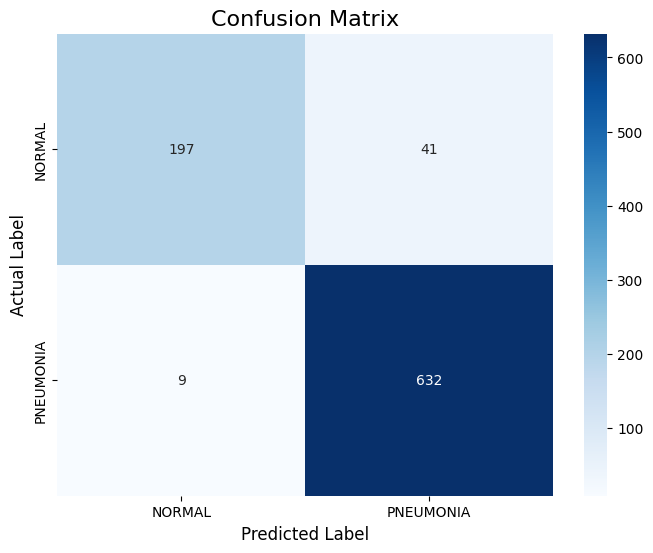

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))

class_labels = list(test_data.class_indices.keys())

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')